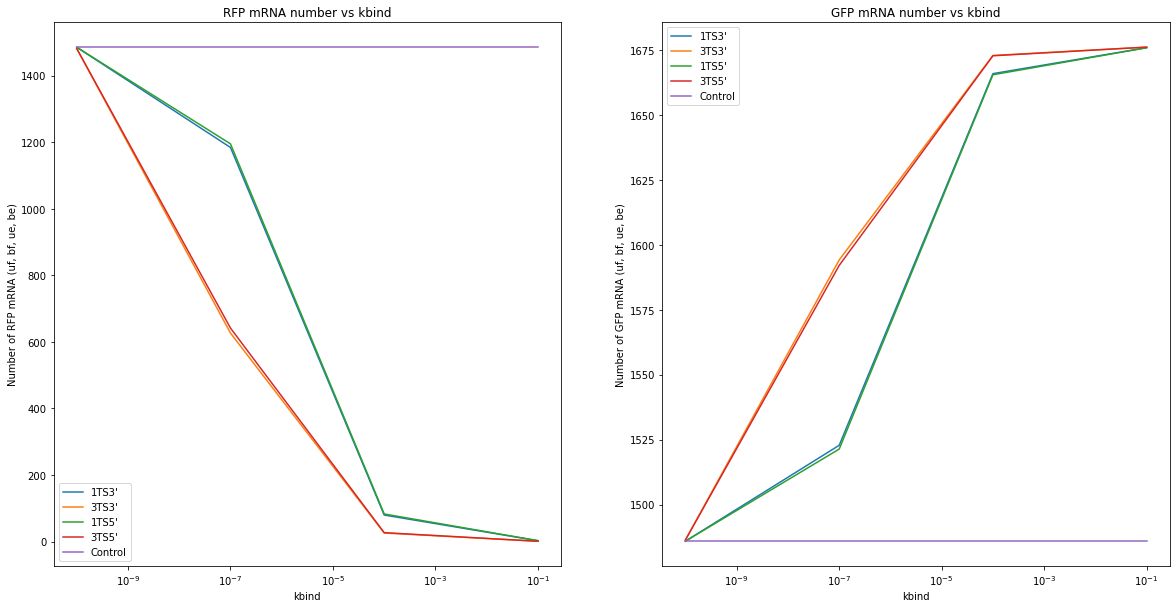

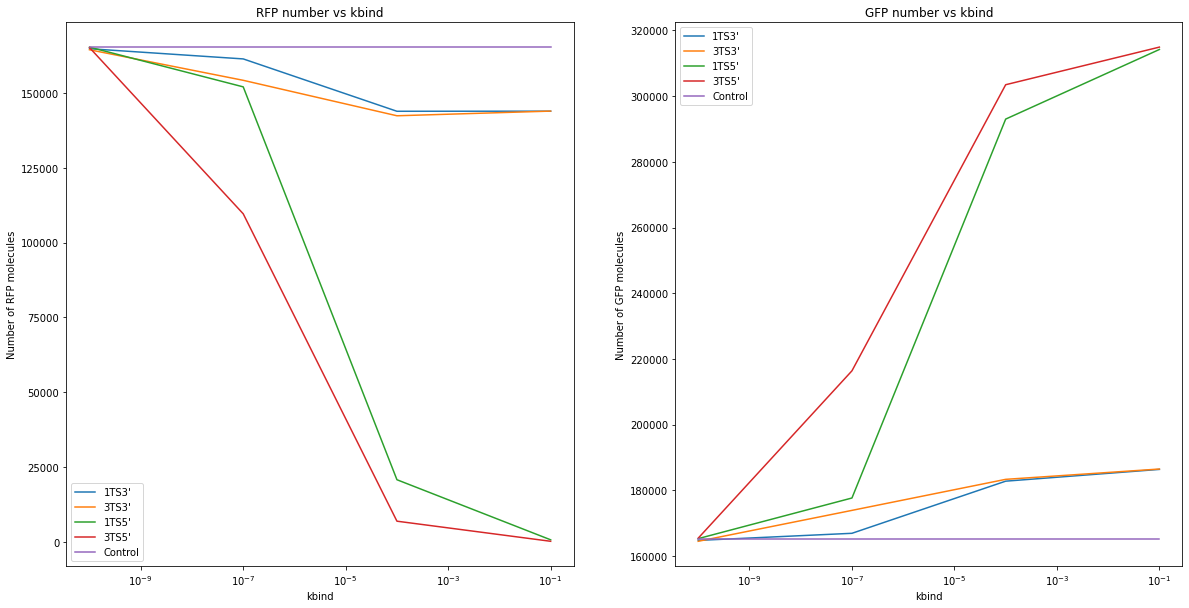

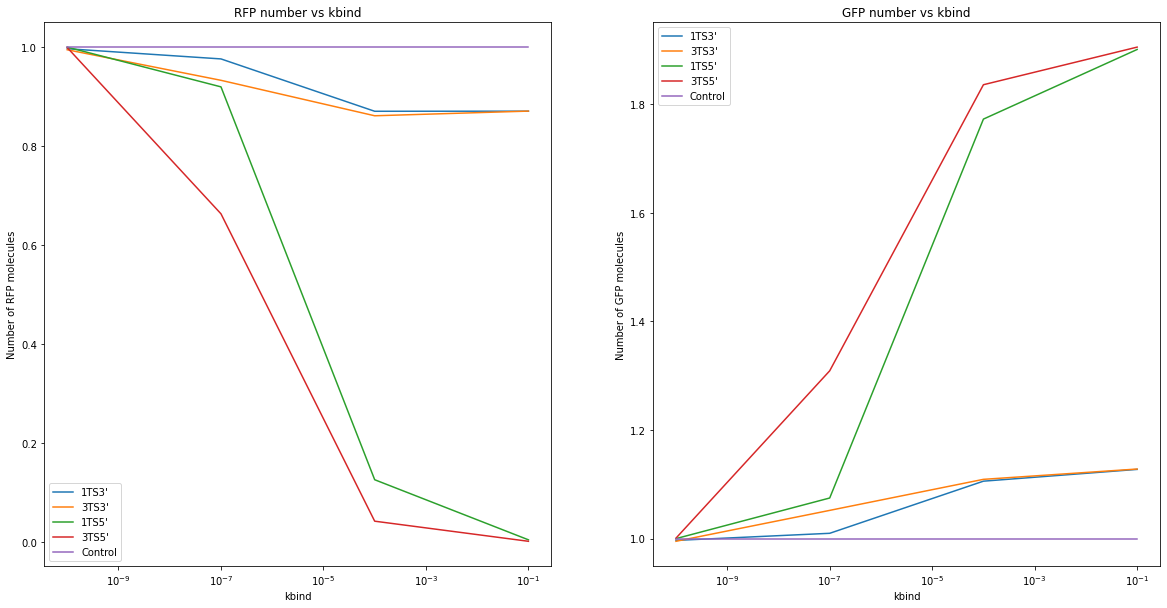

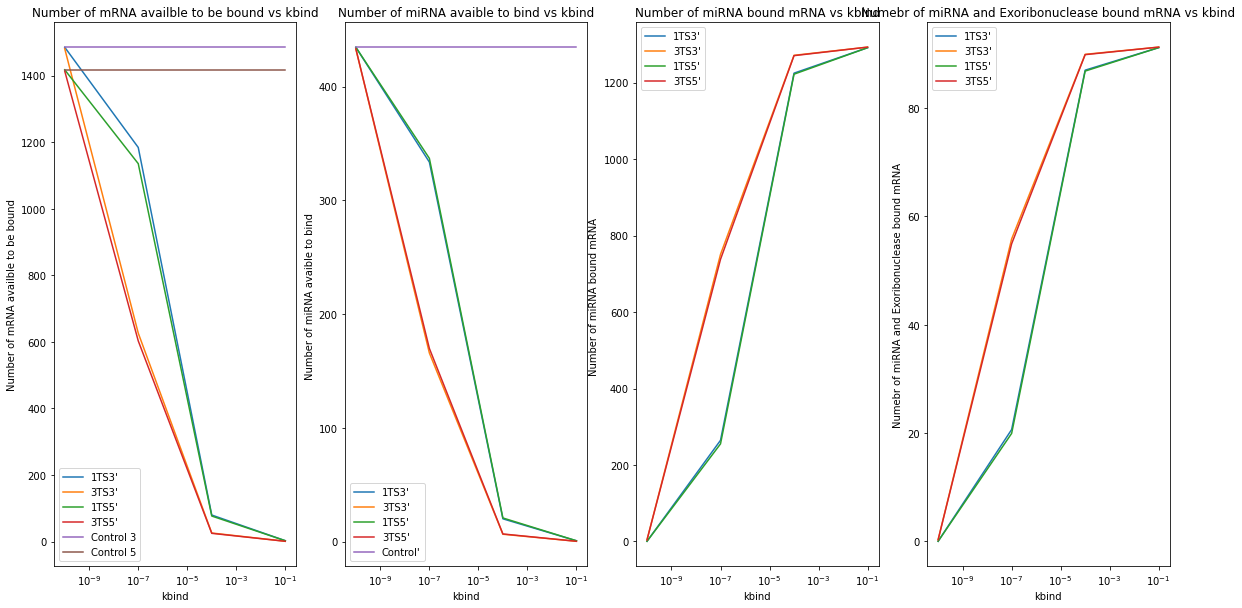

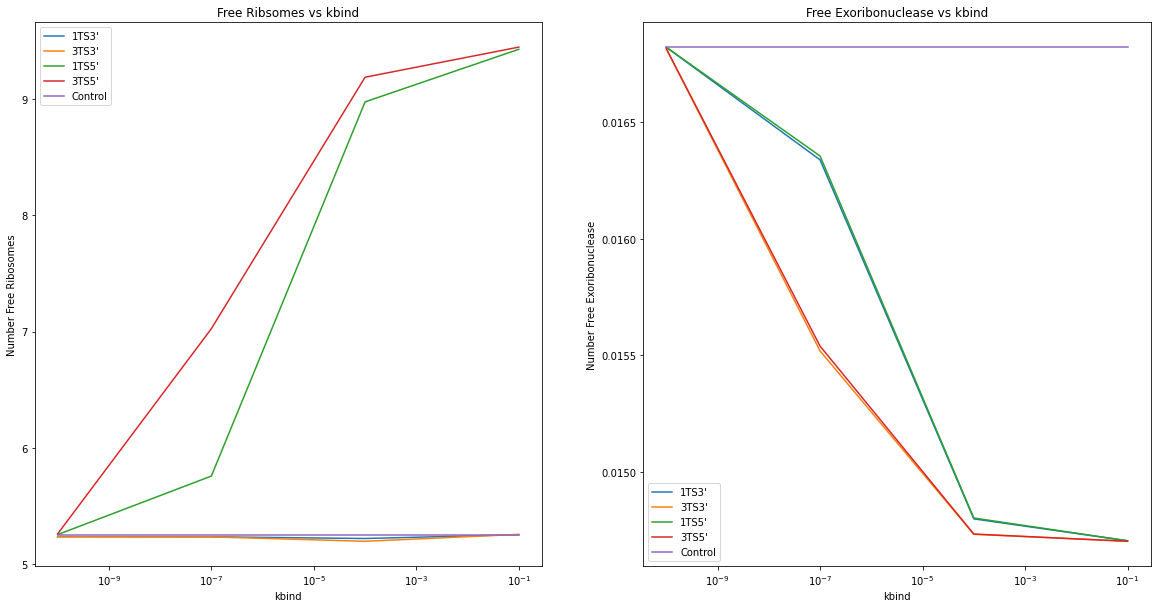

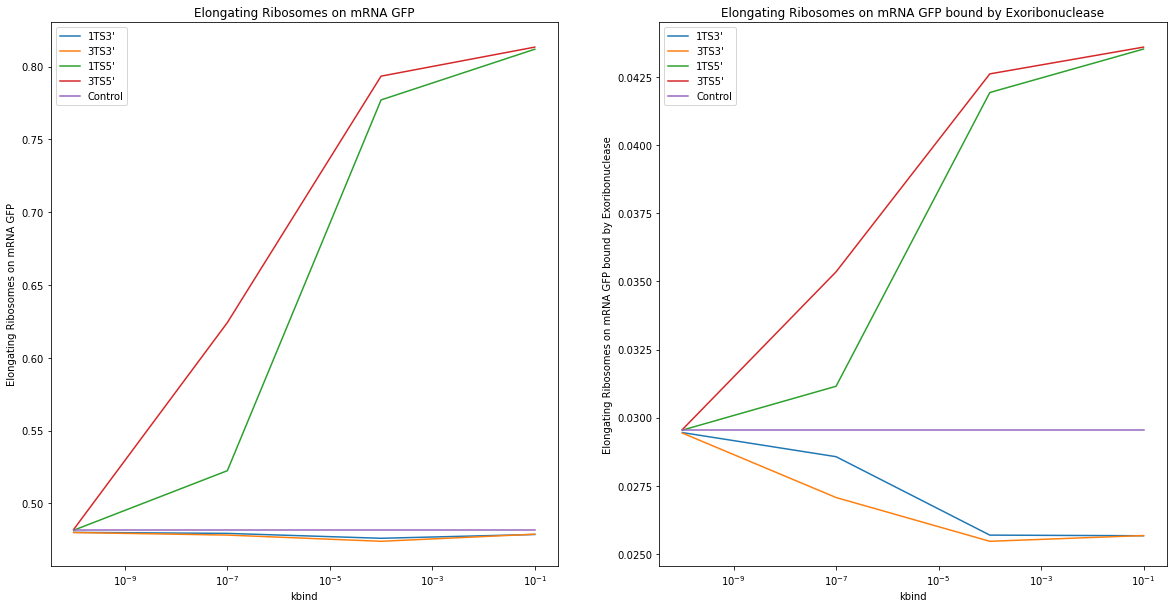

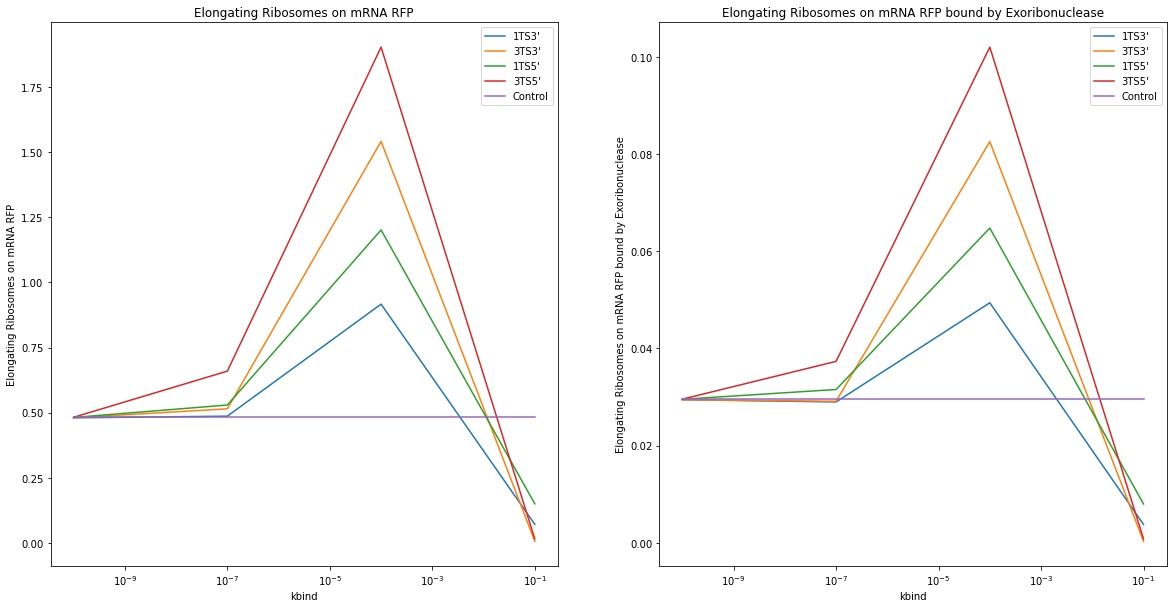

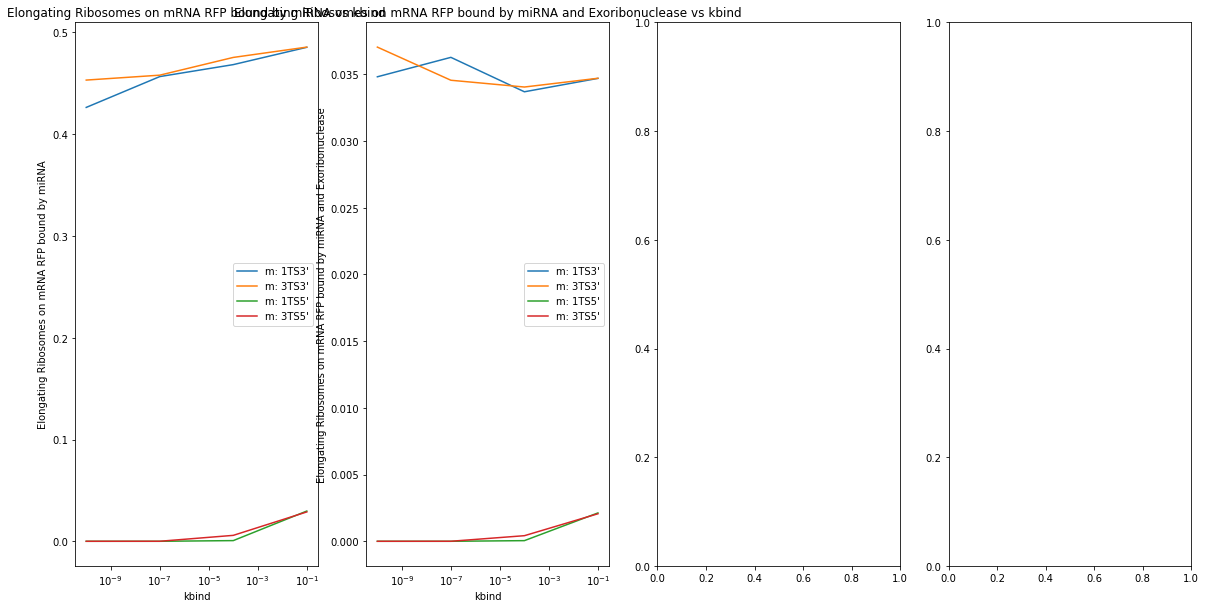

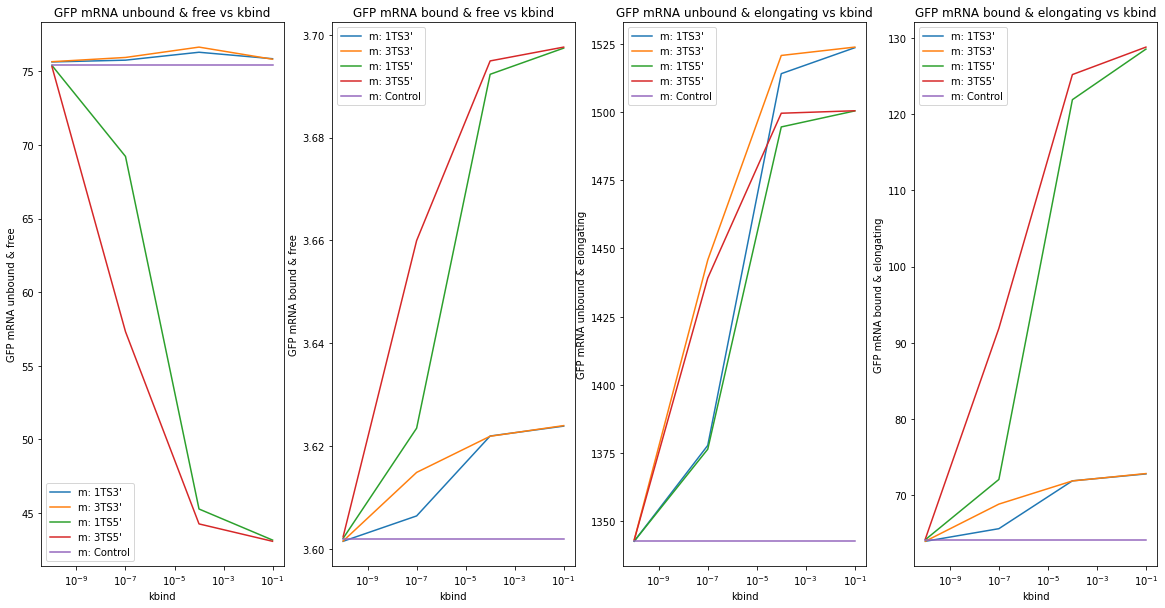

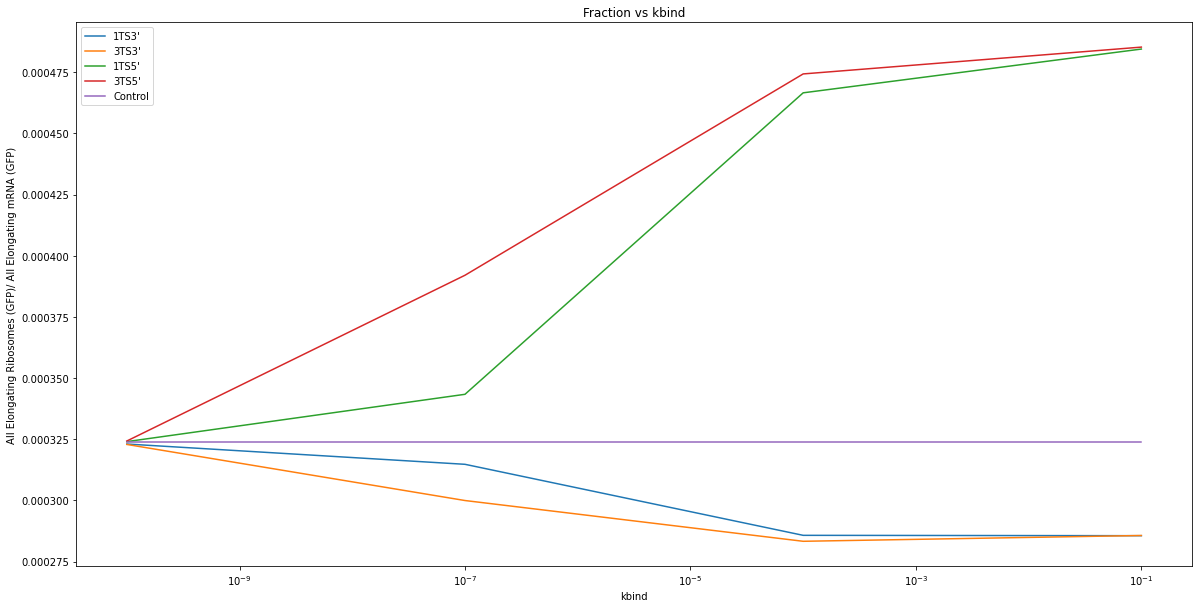

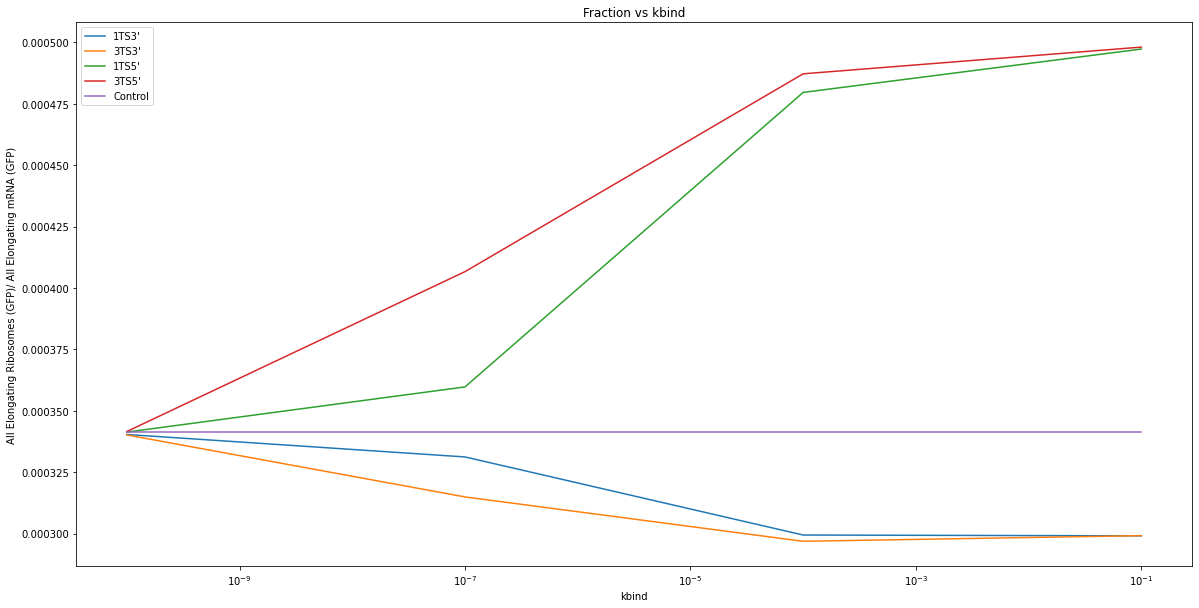

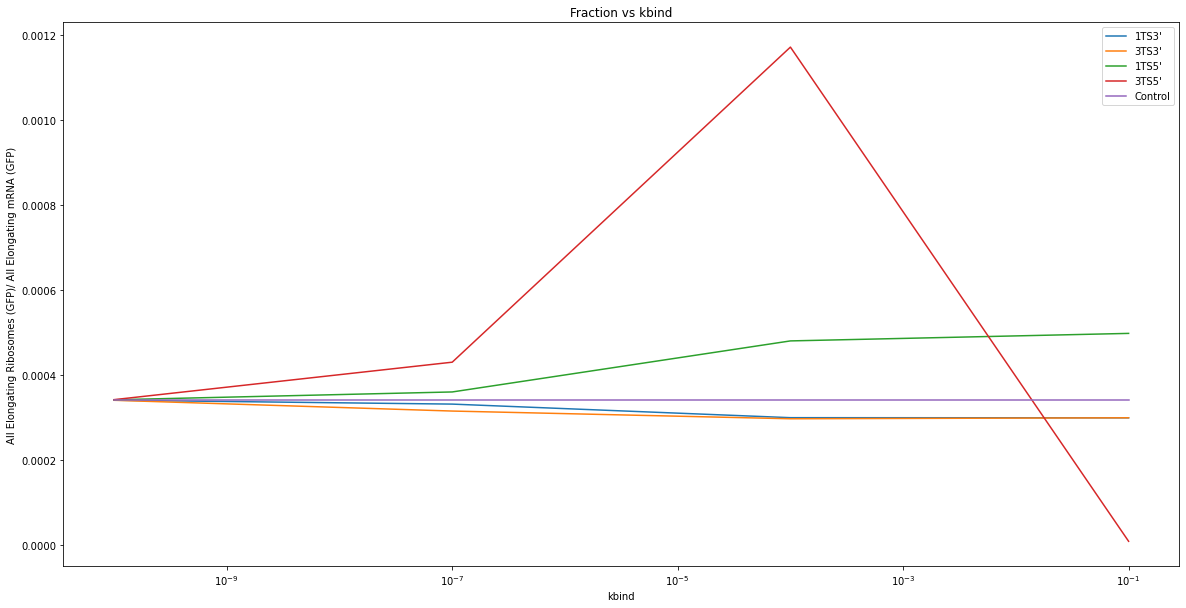

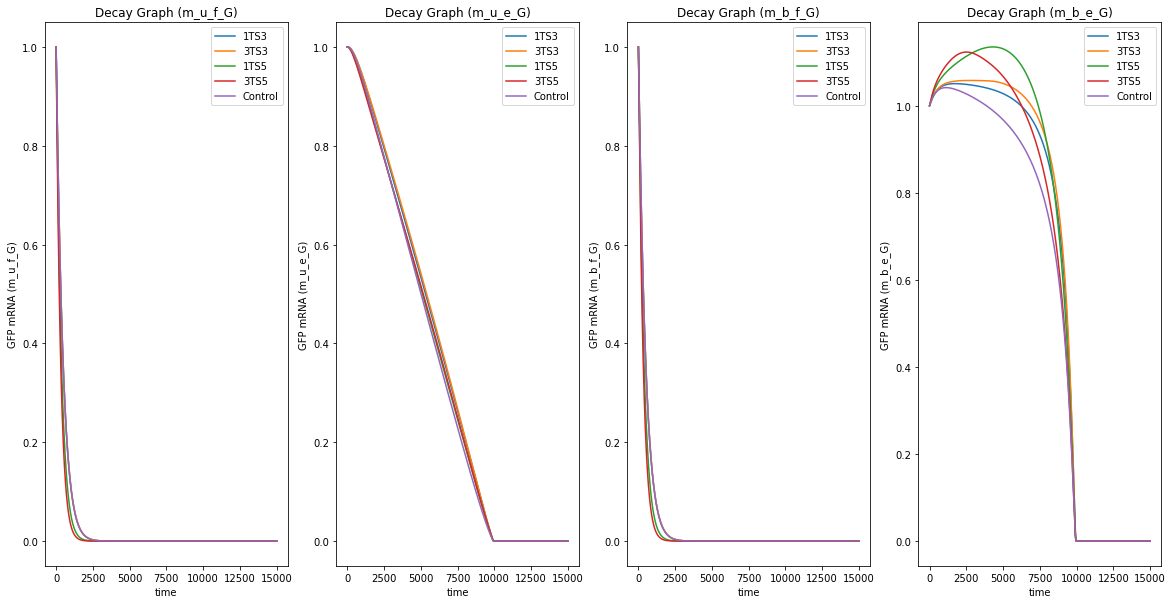

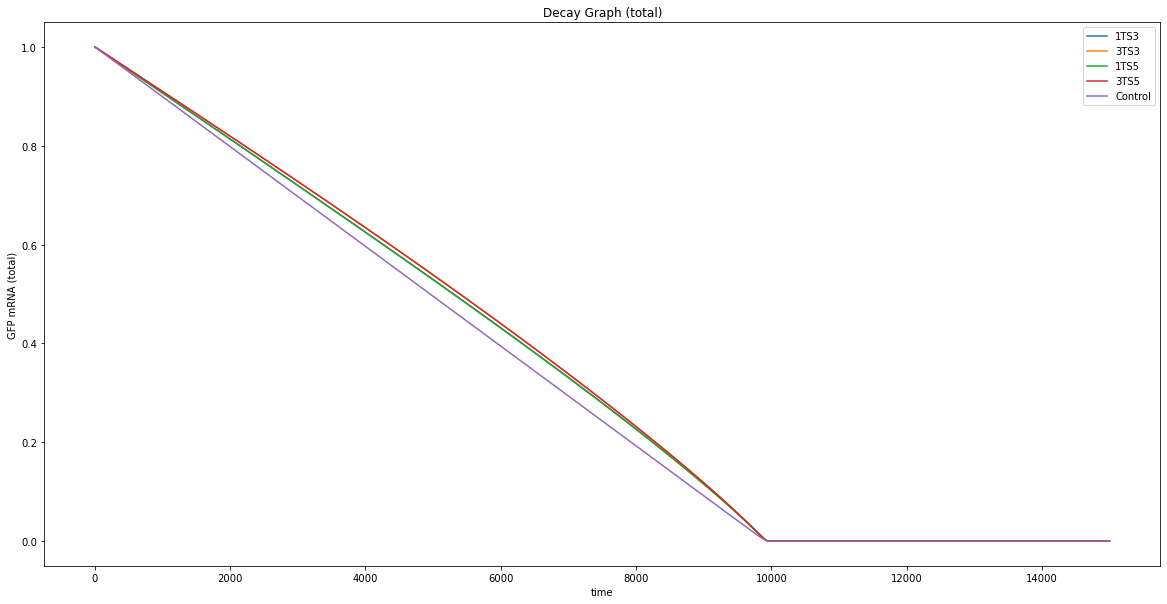

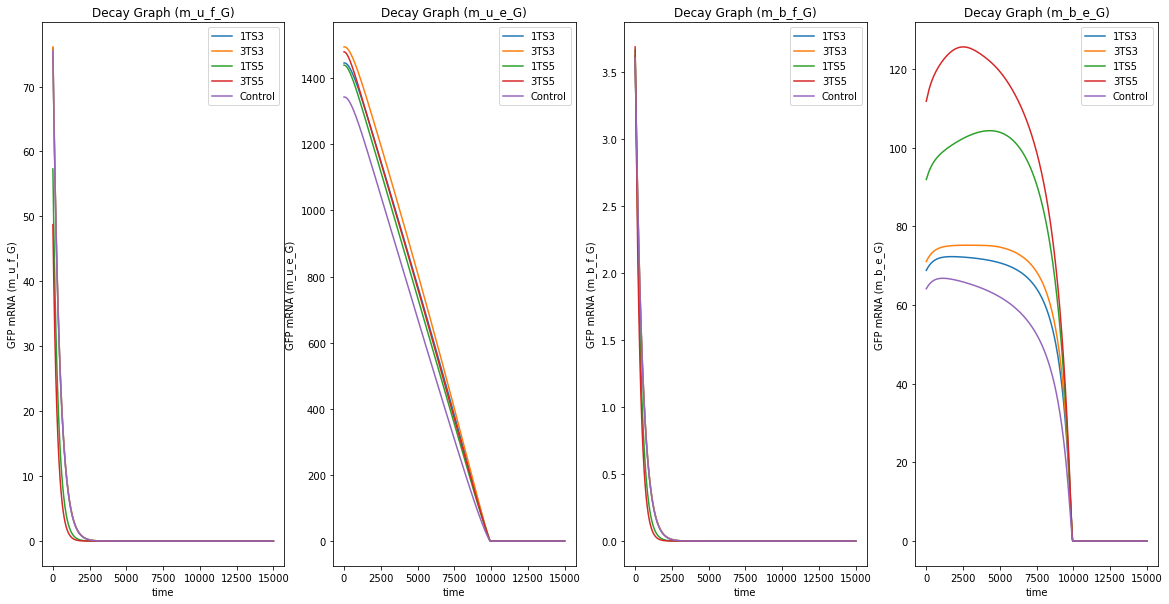

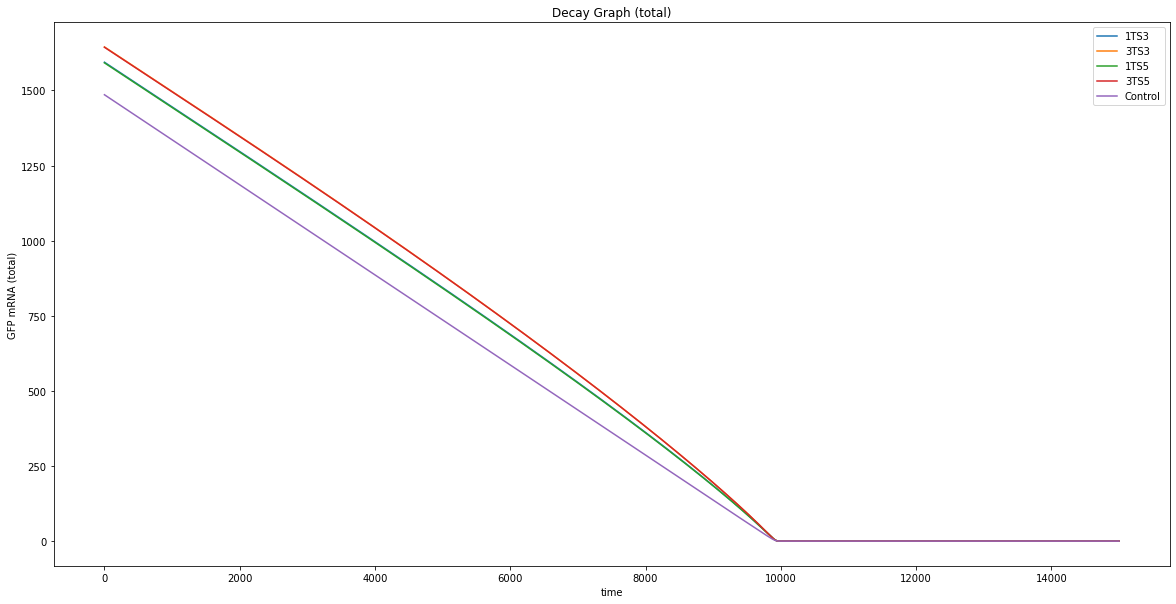

In [2]:
## import numpy as np
import scipy.integrate
from sympy import symbols, Matrix
import math
from sympy.utilities.lambdify import lambdify, implemented_function
import matplotlib.pyplot as plt
from parameter_and_initial_values import time_points

from FullAnalysis import *
from SimultaneousParameterEstimation import SimultaneousParameterEstimation
rate_to_change = "kbind"
rate_array = Rates_values_dict[rate_to_change]*np.logspace(-5, 4, num=4)
graph_RFP_data = np.zeros([5,len(rate_array)])
graph_GFP_data = np.zeros([5,len(rate_array)])
graph_RFP_mRNA_data = np.zeros([5,len(rate_array)])
graph_GFP_mRNA_data = np.zeros([5,len(rate_array)])
graph_RFP_mRNA_bound_ribosomes_data = np.zeros([5,len(rate_array)])
graph_GFP_mRNA_bound_ribosomes_data = np.zeros([5,len(rate_array)])
graph_Exoribonuclease_data = np.zeros([5,len(rate_array)])
graph_Ribosomes_data = np.zeros([5,len(rate_array)])
D_1TS3 = {}
D_3TS3 = {}
D_1TS5 = {}
D_3TS5 = {}
D_Control = {}

D_all = {
    "1TS3" : D_1TS3,
    "3TS3" : D_3TS3,
    "1TS5" : D_1TS5,
    "3TS5" : D_3TS5,
    "_"    : D_Control,
}

GmRNA_transient_breakdown = np.zeros([4, 5, 20000000])
for count_1 in range(5):
    if count_1==0:
        information = [  [ "R" , "full" , "1TS3" ] , [ "G" , "full" , " " ], [ "3" , "mRNA" , "" ]]
        information_label = "1TS3"
    if count_1==1:
        information = [  [ "R" , "full" , "3TS3" ] , [ "G" , "full" , " " ], [ "3" , "mRNA" , "" ]]
        information_label = "3TS3"
    if count_1==2:
        information = [  [ "R" , "full" , "1TS5" ] , [ "G" , "full" , " " ], [ "5" , "mRNA" , "" ]]
        information_label = "1TS5"
    if count_1==3:
        information = [  [ "R" , "full" , "3TS5" ] , [ "G" , "full" , " " ], [ "5" , "mRNA" , "" ]]
        information_label = "3TS5"
    if count_1==4:
        information = [  [ "R" , "full" , "" ] , [ "G" , "full" , " " ],[ "5" , "mRNA" , "" ] ]
        information_label = "_"
        
    import numpy as np
    import scipy.integrate
    from sympy import symbols, Matrix
    import math
    from sympy.utilities.lambdify import lambdify, implemented_function
    import matplotlib.pyplot as plt
    from parameter_and_initial_values import time_points

    full_labels = ["D_u_f", "D_b_f", "D_u_e", "D_b_e", "N", "m_u_f", "m_b_f", "m_u_e", "m_b_e", "R", "P", "X_uf", "X_bf", "X_ue", "X_be", "R_X"]
    mRNA_labels = ["D_u_f", "D_b_f", "D_u_e", "D_b_e", "N", "m_u_f"]
    t_max = 15000*6
    t_short_max = 15000
    n = 20000000

    transcription_rates_syms = symbols("kd_p, kd_m, kd, kd_c")
    translation_rates_syms = symbols("km_p, km_m, km, km_c")
    miBin_rate_syms = symbols("kbind")
    ExoPasBin_rates_syms = symbols("kX_m")
    ExoDeg_rates_syms = symbols("kdeg")
    miPasDil_rates_syms = symbols("lam_mi")
    ProPasDil_rates_syms = symbols("lam_P")
    mi3Rec_rate_syms = symbols("kX_3")
    mi5Rec_rate_syms = symbols("kX_5")

    full_rates_syms = list(transcription_rates_syms+translation_rates_syms)+[ExoPasBin_rates_syms]+[ExoDeg_rates_syms]+[ProPasDil_rates_syms]
    mRNA_rates_syms = list(transcription_rates_syms)+[miPasDil_rates_syms]
    mi3Deg_rates_syms = [miBin_rate_syms] + [mi3Rec_rate_syms] + [ExoDeg_rates_syms] + list(translation_rates_syms)
    mi5Deg_rates_syms = [miBin_rate_syms] + [mi5Rec_rate_syms] + [ExoDeg_rates_syms] +  [list(translation_rates_syms)[3]]
    all_rates_syms = list(transcription_rates_syms+translation_rates_syms)+[miBin_rate_syms]+[ExoPasBin_rates_syms]+[mi3Rec_rate_syms]+[ExoDeg_rates_syms]+[ProPasDil_rates_syms]+[miPasDil_rates_syms]

    species = {}
    species_syms = {}
    species_syms_sens = {}
    ODEs = {}
    rates_syms = {}
    resources_syms = list(symbols("N, R, X"))
    total_species_syms = []

    species["N"], species["R"], species["X"] = 0, 0, 0
    species_syms["N"], species_syms["R"], species_syms["X"] = resources_syms[0], resources_syms[1], resources_syms[2]
    species_syms_sens["N"], species_syms_sens["R"], species_syms_sens["X"] = symbols("N"), symbols("R"), symbols("X")
    ODEs["N"], ODEs["R"], ODEs["X"] = 0, 0, 0

    # Iterate through each species 
    for i in range(len(information)):

        #The information for the current species 
        info = information[i]

        #If current species has a full production pathway, DNA->RNA->Protein
        if info[1] == "full":
            #List for all sub-species
            temp_species_syms = []
            #Iterate through all sub-species
            for j in range(len(full_labels)):
                species[full_labels[j]+"_"+info[0]]=0
                species_syms[full_labels[j]+"_"+info[0]] = symbols(full_labels[j]+"_"+info[0])
                species_syms_sens["S"+full_labels[j]+"_"+info[0]] = symbols("S"+full_labels[j]+"_"+info[0])
                ODEs[full_labels[j]+"_"+info[0]]=0
                temp_species_syms = temp_species_syms + [symbols(full_labels[j]+"_"+info[0])]
            IN = temp_species_syms + resources_syms + full_rates_syms
            out = production_full_pathway(*IN) #Re name function
            for j in range(len(full_labels)):
                ODEs[full_labels[j]+"_"+info[0]] = ODEs[full_labels[j]+"_"+info[0]] + out[j]
            ODEs["N"] = ODEs["N"] + out[-3]
            ODEs["R"] = ODEs["R"] + out[-2]
            ODEs["X"] = ODEs["X"] + out[-1]
            for j in range(len(full_rates_syms)):
                if full_rates_syms[j] not in rates_syms:
                    rates_syms[str(full_rates_syms[j])] = full_rates_syms[j]

        #If current species has a mRNA production pathway, DNA->RNA
        if info[1] == "mRNA":
            #List for all sub-species
            temp_species_syms = []
            #Iterate through all sub-species
            for j in range(len(mRNA_labels)):
                species[mRNA_labels[j]+"_"+info[0]]=0
                species_syms[mRNA_labels[j]+"_"+info[0]] = symbols(mRNA_labels[j]+"_"+info[0])
                species_syms_sens["S"+mRNA_labels[j]+"_"+info[0]] = symbols("S"+mRNA_labels[j]+"_"+info[0])
                ODEs[mRNA_labels[j]+"_"+info[0]]=0
                temp_species_syms = temp_species_syms + [symbols(mRNA_labels[j]+"_"+info[0])]
            IN = temp_species_syms + resources_syms + mRNA_rates_syms
            if info[2]=='':
                out = production_mRNA_pathway_1TS(*IN) #Re name function
            elif info[2][0]=="1":
                    out = production_mRNA_pathway_1TS(*IN) #Re name function
            else:
                out = production_mRNA_pathway_3TS(*IN) #Re name function
            for j in range(len(mRNA_labels)):
                ODEs[mRNA_labels[j]+"_"+info[0]] = ODEs[mRNA_labels[j]+"_"+info[0]] + out[j]
            ODEs["N"] = ODEs["N"] + out[-1]
            for j in range(len(mRNA_rates_syms)):
                if mRNA_rates_syms[j] not in rates_syms:
                    rates_syms[str(mRNA_rates_syms[j])] = mRNA_rates_syms[j]

    for i in range(len(information)):

        #The information for the current species 
        info = information[i]

        #If current species is regulated by 3'miRNA
        if info[2] == "1TS3":        
            mi3_labels = [["m_u_f_"+info[0], "m_b_f_"+info[0], "m_u_e_"+info[0], "m_b_e_"+info[0], "mi_uf3_"+info[0], "mi_bf3_"+info[0], "mi_ue3_"+info[0], "mi_be3_"+info[0], "X_uf3_"+info[0], "X_bf3_"+info[0], "X_ue3_"+info[0], "X_be3_"+info[0], "m_u_f_3", "X", "R", "R_"+info[0], "R_3_"+info[0], "R_X3_"+info[0], "P_"+info[0]]]
            #Iterate through all sub-species
            for k in range(len(mi3_labels)):
                temp_species_syms = []
                for j in range(len(mi3_labels[k])):
                    if mi3_labels[k][j] in species:
                        temp_species_syms = temp_species_syms + [species_syms[mi3_labels[k][j]]]
                    else:
                        species[mi3_labels[k][j]]=0
                        species_syms[mi3_labels[k][j]] = symbols(mi3_labels[k][j])
                        species_syms_sens["S"+mi3_labels[k][j]] = symbols("S"+mi3_labels[k][j])
                        ODEs[mi3_labels[k][j]]=0
                        temp_species_syms = temp_species_syms + [symbols(mi3_labels[k][j])]
                IN = temp_species_syms + mi3Deg_rates_syms
                out =  mRNA_3miRNAdegradation_fullpathway(*tuple(list(IN)+[1]))
                for j in range(len(mi3_labels[k])):
                    ODEs[mi3_labels[k][j]] = ODEs[mi3_labels[k][j]] + out[j]
                for j in range(len(mi3Deg_rates_syms)):
                    if mi3Deg_rates_syms[j] not in rates_syms:
                        rates_syms[str(mi3Deg_rates_syms[j])] = mi3Deg_rates_syms[j]


        if info[2] == "1TS5":
            mi5_labels = ["m_u_f_"+info[0], "m_u_e_"+info[0], "m_b_e_"+info[0], "mi_uf5_"+info[0], "mi_ue5_"+info[0], "X_uf5_"+info[0], "X_ue5_"+info[0], "m_u_f_5", "X", "R", "R_"+info[0], "R_5_"+info[0], "R_X5_"+info[0], "P_"+info[0]]
            #Iterate through all sub-species
            temp_species_syms = []
            for j in range(len(mi5_labels)):
                if mi5_labels[j] in species:
                    temp_species_syms = temp_species_syms + [species_syms[mi5_labels[j]]]
                else:
                    species[mi5_labels[j]]=0
                    species_syms[mi5_labels[j]] = symbols(mi5_labels[j])
                    species_syms_sens["S"+mi5_labels[j]] = symbols("S"+mi5_labels[j])
                    ODEs[mi5_labels[j]]=0
                    temp_species_syms = temp_species_syms + [symbols(mi5_labels[j])]
            IN = temp_species_syms + mi5Deg_rates_syms
            out =  mRNA_5miRNAdegradation_fullpathway(*tuple(list(IN)+[1]))
            for j in range(len(mi5_labels)):
                ODEs[mi5_labels[j]] = ODEs[mi5_labels[j]] + out[j]
            for j in range(len(mi5Deg_rates_syms)):
                if mi5Deg_rates_syms[j] not in rates_syms:
                    rates_syms[str(mi5Deg_rates_syms[j])] = mi5Deg_rates_syms[j]


        if info[2] == "3TS3":

            mi3_labels = [["m_u_f_"+info[0], "m_b_f_"+info[0], "m_u_e_"+info[0], "m_b_e_"+info[0], "mi_uf3_"+info[0], "mi_bf3_"+info[0], "mi_ue3_"+info[0], "mi_be3_"+info[0], "X_uf3_"+info[0], "X_bf3_"+info[0], "X_ue3_"+info[0], "X_be3_"+info[0], "m_u_f_3", "X", "R", "R_"+info[0], "R_3_"+info[0], "R_X3_"+info[0], "P_"+info[0]]]
            #Iterate through all sub-species
            for k in range(len(mi3_labels)):
                temp_species_syms = []
                for j in range(len(mi3_labels[k])):
                    if mi3_labels[k][j] in species:
                        temp_species_syms = temp_species_syms + [species_syms[mi3_labels[k][j]]]
                    else:
                        species[mi3_labels[k][j]]=0
                        species_syms[mi3_labels[k][j]] = symbols(mi3_labels[k][j])
                        species_syms_sens["S"+mi3_labels[k][j]] = symbols("S"+mi3_labels[k][j])
                        ODEs[mi3_labels[k][j]]=0
                        temp_species_syms = temp_species_syms + [symbols(mi3_labels[k][j])]
                IN = temp_species_syms + mi3Deg_rates_syms
                out =  mRNA_3miRNAdegradation_fullpathway(*tuple(list(IN)+[10]))
                for j in range(len(mi3_labels[k])):
                    ODEs[mi3_labels[k][j]] = ODEs[mi3_labels[k][j]] + out[j]
                for j in range(len(mi3Deg_rates_syms)):
                    if mi3Deg_rates_syms[j] not in rates_syms:
                        rates_syms[str(mi3Deg_rates_syms[j])] = mi3Deg_rates_syms[j]


        if info[2] == "3TS5":
            mi5_labels = ["m_u_f_"+info[0], "m_u_e_"+info[0], "m_b_e_"+info[0], "mi_uf5_"+info[0], "mi_ue5_"+info[0], "X_uf5_"+info[0], "X_ue5_"+info[0], "m_u_f_5", "X", "R", "R_"+info[0], "R_5_"+info[0], "R_X5_"+info[0], "P_"+info[0]]
            #Iterate through all sub-species
            temp_species_syms = []
            for j in range(len(mi5_labels)):
                if mi5_labels[j] in species:
                    temp_species_syms = temp_species_syms + [species_syms[mi5_labels[j]]]
                else:
                    species[mi5_labels[j]]=0
                    species_syms[mi5_labels[j]] = symbols(mi5_labels[j])
                    species_syms_sens["S"+mi5_labels[j]] = symbols("S"+mi5_labels[j])
                    ODEs[mi5_labels[j]]=0
                    temp_species_syms = temp_species_syms + [symbols(mi5_labels[j])]
            IN = temp_species_syms + mi5Deg_rates_syms
            out =  mRNA_5miRNAdegradation_fullpathway(*tuple(list(IN)+[10]))
            for j in range(len(mi5_labels)):
                ODEs[mi5_labels[j]] = ODEs[mi5_labels[j]] + out[j]
            for j in range(len(mi5Deg_rates_syms)):
                if mi5Deg_rates_syms[j] not in rates_syms:
                    rates_syms[str(mi5Deg_rates_syms[j])] = mi5Deg_rates_syms[j]

    for s in species.keys():
        D_all[information_label][s] = np.zeros(len(rate_array))

    ODEs_list = list(ODEs.values())
    ODEs_array = np.array(ODEs_list)
    reaction_function = lambdify(list(species_syms.values())  + list(rates_syms.values()), ODEs_array) 
    
    def model(y, t, reaction_function, args):
        return reaction_function(*y, *args)

    Initial_values = [Initial_values_dict[i] for i in species_syms.keys()]
    Rates_values = [Rates_values_dict[i] for i in rates_syms.keys()]
    
    t = np.linspace(0, t_max, n) 
    t_short = np.linspace(0, t_short_max, n) 
    for count_2, rate_value in enumerate(rate_array):
        Rates_values_edit = Rates_values
        if information_label[-1]!="_":
            Rates_values_edit[list(rates_syms.keys()).index(rate_to_change)] = rate_value
        simulation_results = scipy.integrate.odeint(model, Initial_values, t, args=(reaction_function, Rates_values_edit))
        for num, s in enumerate(species.keys()):
            D_all[information_label][s][count_2] = simulation_results[-1,num]
            
    if information_label!="_":        
        Rates_values_edit[list(rates_syms.keys()).index(rate_to_change)] = 10**-6
        simulation_results = scipy.integrate.odeint(model, Initial_values, t, args=(reaction_function, Rates_values_edit))
    else:
        simulation_results = scipy.integrate.odeint(model, Initial_values, t, args=(reaction_function, Rates_values_edit))
    Rates_values_edit[list(rates_syms.keys()).index("kd_c")] = 0
    
    simulation_results = scipy.integrate.odeint(model, simulation_results[-1,:], t_short, args=(reaction_function, Rates_values_edit))
    
    for num, s in enumerate(species.keys()):
        if s == "m_u_f_G":
            GmRNA_transient_breakdown[0,count_1,:] = simulation_results[:,num]
        if s == "m_u_e_G":
            GmRNA_transient_breakdown[1,count_1,:] = simulation_results[:,num]
        if s == "m_b_f_G":
            GmRNA_transient_breakdown[2,count_1,:] = simulation_results[:,num]
        if s == "m_b_e_G":
            GmRNA_transient_breakdown[3,count_1,:] = simulation_results[:,num]
            
# plot_labels = ["1TS3", "3TS3", "1TS5", "3TS5", "_"]
# plot_labels_legend = ["1TS3", "3TS3", "1TS5", "3TS5", "Control"]
# plot_graphs = [["P_R"], ["P_G"]]
# plot_graphs_label = ["RFP", "GFP"]
# for m, n in zip(plot_graphs, plot_graphs_label):
#     fig, axs = plt.subplots(1, 1, figsize=(20, 10))
#     for i, j in zip(plot_labels, plot_labels_legend):
#         axs.plot(rate_array, sum([D_all[i][iteration] for iteration in m])/sum([D_all["_"][iteration] for iteration in m]),label=j+" "+n)
#     axs.set_title(n+" vs "+rate_to_change+" rate")
#     axs.set_xlabel(rate_to_change+" rate")
#     axs.set_ylabel(n)
#     axs.legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ['m_u_f_R', 'm_b_f_R', 'm_u_e_R', 'm_b_e_R']]), label="1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ['m_u_f_R', 'm_b_f_R', 'm_u_e_R', 'm_b_e_R']]), label="3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ['m_u_f_R', 'm_b_f_R', 'm_u_e_R', 'm_b_e_R']]), label="1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ['m_u_f_R', 'm_b_f_R', 'm_u_e_R', 'm_b_e_R']]), label="3TS5'")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ['m_u_f_R', 'm_b_f_R', 'm_u_e_R', 'm_b_e_R']]), label="Control")
axs[0].set_title("RFP mRNA number vs kbind")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("Number of RFP mRNA (uf, bf, ue, be)")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ['m_u_f_G', 'm_b_f_G', 'm_u_e_G', 'm_b_e_G']]), label="1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ['m_u_f_G', 'm_b_f_G', 'm_u_e_G', 'm_b_e_G']]), label="3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ['m_u_f_G', 'm_b_f_G', 'm_u_e_G', 'm_b_e_G']]), label="1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ['m_u_f_G', 'm_b_f_G', 'm_u_e_G', 'm_b_e_G']]), label="3TS5'")
axs[1].plot(rate_array, sum([D_all["_"][iteration] for iteration in ['m_u_f_G', 'm_b_f_G', 'm_u_e_G', 'm_b_e_G']]), label="Control")
axs[1].set_title("GFP mRNA number vs kbind")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("Number of GFP mRNA (uf, bf, ue, be)")
axs[1].legend()    
axs[1].set_xscale('log')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["P_R"]]),label="1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["P_R"]]),label="3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["P_R"]]),label="1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["P_R"]]),label="3TS5'")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["P_R"]]),label="Control")
axs[0].set_title("RFP number vs kbind")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("Number of RFP molecules")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["P_G"]]),label="1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["P_G"]]),label="3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["P_G"]]),label="1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["P_G"]]),label="3TS5'")
axs[1].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["P_G"]]),label="Control")
axs[1].set_title("GFP number vs kbind")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("Number of GFP molecules")
axs[1].legend()    
axs[1].set_xscale('log')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["P_R"]])/D_all["_"]["P_R"],label="1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["P_R"]])/D_all["_"]["P_R"],label="3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["P_R"]])/D_all["_"]["P_R"],label="1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["P_R"]])/D_all["_"]["P_R"],label="3TS5'")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["P_R"]])/D_all["_"]["P_R"],label="Control")
axs[0].set_title("RFP number vs kbind")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("Number of RFP molecules")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["P_G"]])/D_all["_"]["P_G"],label="1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["P_G"]])/D_all["_"]["P_G"],label="3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["P_G"]])/D_all["_"]["P_G"],label="1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["P_G"]])/D_all["_"]["P_G"],label="3TS5'")
axs[1].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["P_G"]])/D_all["_"]["P_G"],label="Control")
axs[1].set_title("GFP number vs kbind")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("Number of GFP molecules")
axs[1].legend()    
axs[1].set_xscale('log')


fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ['m_u_f_R', 'm_b_f_R', 'm_u_e_R', 'm_b_e_R']]),label="1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ['m_u_f_R', 'm_b_f_R', 'm_u_e_R', 'm_b_e_R']]),label="3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ['m_u_f_R', 'm_u_e_R']]),label="1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ['m_u_f_R', 'm_u_e_R']]),label="3TS5'")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ['m_u_f_R', 'm_b_f_R', 'm_u_e_R', 'm_b_e_R']]),label="Control 3")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ['m_u_f_R', 'm_u_e_R']]),label="Control 5")
axs[0].set_title("Number of mRNA availble to be bound vs kbind")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("Number of mRNA availble to be bound")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ['m_u_f_3']]),label="1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ['m_u_f_3']]),label="3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ['m_u_f_5']]),label="1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ['m_u_f_5']]),label="3TS5'")
axs[1].plot(rate_array, sum([D_all["_"][iteration] for iteration in ['m_u_f_5']]),label="Control'")
axs[1].set_title("Number of miRNA avaible to bind vs kbind")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("Number of miRNA avaible to bind ")
axs[1].legend()
axs[1].set_xscale('log')
axs[2].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ['mi_uf3_R', 'mi_bf3_R', 'mi_ue3_R', 'mi_be3_R']]),label="1TS3'")
axs[2].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ['mi_uf3_R', 'mi_bf3_R', 'mi_ue3_R', 'mi_be3_R']]),label="3TS3'")
axs[2].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ['mi_uf5_R', 'mi_ue5_R' ]]),label="1TS5'")
axs[2].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ['mi_uf5_R', 'mi_ue5_R' ]]),label="3TS5'")
axs[2].set_title("Number of miRNA bound mRNA vs kbind")
axs[2].set_xlabel("kbind")
axs[2].set_ylabel("Number of miRNA bound mRNA ")
axs[2].legend()
axs[2].set_xscale('log')
axs[3].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ['X_uf3_R', 'X_bf3_R', 'X_ue3_R', 'X_be3_R']]),label="1TS3'")
axs[3].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ['X_uf3_R', 'X_bf3_R', 'X_ue3_R', 'X_be3_R']]),label="3TS3'")
axs[3].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ['X_uf5_R', 'X_ue5_R']]),label="1TS5'")
axs[3].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ['X_uf5_R', 'X_ue5_R']]),label="3TS5'")
axs[3].set_title("Numebr of miRNA and Exoribonuclease bound mRNA vs kbind")
axs[3].set_xlabel("kbind")
axs[3].set_ylabel("Numebr of miRNA and Exoribonuclease bound mRNA")
axs[3].legend()
axs[3].set_xscale('log')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R"]]),label="1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R"]]),label="3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R"]]),label="1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R"]]),label="3TS5'")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["R"]]),label="Control")
axs[0].set_title("Free Ribsomes vs kbind")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("Number Free Ribosomes")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["X"]]),label="1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["X"]]),label="3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["X"]]),label="1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["X"]]),label="3TS5'")
axs[1].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["X"]]),label="Control")
axs[1].set_title("Free Exoribonuclease vs kbind")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("Number Free Exoribonuclease")
axs[1].legend()
axs[1].set_xscale('log')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_G"]]),label="1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_G"]]),label="3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_G"]]),label="1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_G"]]),label="3TS5'")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["R_G"]]),label="Control")
axs[0].set_title("Elongating Ribosomes on mRNA GFP")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("Elongating Ribosomes on mRNA GFP")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_X_G"]]),label="1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_X_G"]]),label="3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_X_G"]]),label="1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_X_G"]]),label="3TS5'")
axs[1].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["R_X_G"]]),label="Control")
axs[1].set_title("Elongating Ribosomes on mRNA GFP bound by Exoribonuclease")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("Elongating Ribosomes on mRNA GFP bound by Exoribonuclease")
axs[1].legend()
axs[1].set_xscale('log')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_R"]]),label="1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_R"]]),label="3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_R"]]),label="1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_R"]]),label="3TS5'")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["R_R"]]),label="Control")
axs[0].set_title("Elongating Ribosomes on mRNA RFP")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("Elongating Ribosomes on mRNA RFP")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_X_R"]]),label="1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_X_R"]]),label="3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_X_R"]]),label="1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_X_R"]]),label="3TS5'")
axs[1].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["R_X_R"]]),label="Control")
axs[1].set_title("Elongating Ribosomes on mRNA RFP bound by Exoribonuclease")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("Elongating Ribosomes on mRNA RFP bound by Exoribonuclease")
axs[1].legend()
axs[1].set_xscale('log')

fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_3_R"]]),label="m: 1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_3_R"]]),label="m: 3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_5_R"]]),label="m: 1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_5_R"]]),label="m: 3TS5'")
axs[0].set_title("Elongating Ribosomes on mRNA RFP bound by miRNA vs kbind")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("Elongating Ribosomes on mRNA RFP bound by miRNA")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_X3_R"]]),label="m: 1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_X3_R"]]),label="m: 3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_X5_R"]]),label="m: 1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_X5_R"]]),label="m: 3TS5'")
axs[1].set_title("Elongating Ribosomes on mRNA RFP bound by miRNA and Exoribonuclease vs kbind")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("Elongating Ribosomes on mRNA RFP bound by miRNA and Exoribonuclease")
axs[1].legend()
axs[1].set_xscale('log')

fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["m_u_f_G"]]),label="m: 1TS3'")
axs[0].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["m_u_f_G"]]),label="m: 3TS3'")
axs[0].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["m_u_f_G"]]),label="m: 1TS5'")
axs[0].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["m_u_f_G"]]),label="m: 3TS5'")
axs[0].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["m_u_f_G"]]),label="m: Control")
axs[0].set_title("GFP mRNA unbound & free vs kbind")
axs[0].set_xlabel("kbind")
axs[0].set_ylabel("GFP mRNA unbound & free")
axs[0].legend()
axs[0].set_xscale('log')
axs[1].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["m_b_f_G"]]),label="m: 1TS3'")
axs[1].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["m_b_f_G"]]),label="m: 3TS3'")
axs[1].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["m_b_f_G"]]),label="m: 1TS5'")
axs[1].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["m_b_f_G"]]),label="m: 3TS5'")
axs[1].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["m_b_f_G"]]),label="m: Control")
axs[1].set_title("GFP mRNA bound & free vs kbind")
axs[1].set_xlabel("kbind")
axs[1].set_ylabel("GFP mRNA bound & free")
axs[1].legend()
axs[1].set_xscale('log')
axs[2].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["m_u_e_G"]]),label="m: 1TS3'")
axs[2].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["m_u_e_G"]]),label="m: 3TS3'")
axs[2].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["m_u_e_G"]]),label="m: 1TS5'")
axs[2].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["m_u_e_G"]]),label="m: 3TS5'")
axs[2].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["m_u_e_G"]]),label="m: Control")
axs[2].set_title("GFP mRNA unbound & elongating vs kbind")
axs[2].set_xlabel("kbind")
axs[2].set_ylabel("GFP mRNA unbound & elongating")
axs[2].legend()
axs[2].set_xscale('log')
axs[3].plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["m_b_e_G"]]),label="m: 1TS3'")
axs[3].plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["m_b_e_G"]]),label="m: 3TS3'")
axs[3].plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["m_b_e_G"]]),label="m: 1TS5'")
axs[3].plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["m_b_e_G"]]),label="m: 3TS5'")
axs[3].plot(rate_array, sum([D_all["_"][iteration] for iteration in ["m_b_e_G"]]),label="m: Control")
axs[3].set_title("GFP mRNA bound & elongating vs kbind")
axs[3].set_xlabel("kbind")
axs[3].set_ylabel("GFP mRNA bound & elongating")
axs[3].legend()
axs[3].set_xscale('log')



fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_G"]])/ sum([D_all["1TS3"][iteration] for iteration in ["m_u_f_G", "m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="1TS3'")
axs.plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_G"]])/ sum([D_all["3TS3"][iteration] for iteration in ["m_u_f_G", "m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="3TS3'")
axs.plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_G"]])/ sum([D_all["1TS5"][iteration] for iteration in ["m_u_f_G", "m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="1TS5'")
axs.plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_G"]])/ sum([D_all["3TS5"][iteration] for iteration in ["m_u_f_G", "m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="3TS5'")
axs.plot(rate_array, sum([D_all["_"][iteration] for iteration in ["R_G"]])/ sum([D_all["_"][iteration] for iteration in ["m_u_f_G", "m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="Control")
axs.set_title("Fraction vs kbind")
axs.set_xlabel("kbind")
axs.set_ylabel("All Elongating Ribosomes (GFP)/ All Elongating mRNA (GFP)")
axs.legend()
axs.set_xscale('log')
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_G"]])/ sum([D_all["1TS3"][iteration] for iteration in ["m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="1TS3'")
axs.plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_G"]])/ sum([D_all["3TS3"][iteration] for iteration in ["m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="3TS3'")
axs.plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_G"]])/ sum([D_all["1TS5"][iteration] for iteration in ["m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="1TS5'")
axs.plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_G"]])/ sum([D_all["3TS5"][iteration] for iteration in ["m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="3TS5'")
axs.plot(rate_array, sum([D_all["_"][iteration] for iteration in ["R_G"]])/ sum([D_all["_"][iteration] for iteration in ["m_b_f_G", "m_u_e_G", "m_b_e_G"]]),label="Control")
axs.set_title("Fraction vs kbind")
axs.set_xlabel("kbind")
axs.set_ylabel("All Elongating Ribosomes (GFP)/ All Elongating mRNA (GFP)")
axs.legend()
axs.set_xscale('log')
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.plot(rate_array, sum([D_all["1TS3"][iteration] for iteration in ["R_G"]])/ sum([D_all["1TS3"][iteration] for iteration in ["m_u_e_G", "m_b_e_G"]]),label="1TS3'")
axs.plot(rate_array, sum([D_all["3TS3"][iteration] for iteration in ["R_G"]])/ sum([D_all["3TS3"][iteration] for iteration in ["m_u_e_G", "m_b_e_G"]]),label="3TS3'")
axs.plot(rate_array, sum([D_all["1TS5"][iteration] for iteration in ["R_G"]])/ sum([D_all["1TS5"][iteration] for iteration in ["m_u_e_G", "m_b_e_G"]]),label="1TS5'")
axs.plot(rate_array, sum([D_all["3TS5"][iteration] for iteration in ["R_R"]])/ sum([D_all["3TS5"][iteration] for iteration in ["m_u_e_G", "m_b_e_G"]]),label="3TS5'")
axs.plot(rate_array, sum([D_all["_"][iteration] for iteration in ["R_G"]])/ sum([D_all["_"][iteration] for iteration in ["m_u_e_G", "m_b_e_G"]]),label="Control")
axs.set_title("Fraction vs kbind")
axs.set_xlabel("kbind")
axs.set_ylabel("All Elongating Ribosomes (GFP)/ All Elongating mRNA (GFP)")
axs.legend()
axs.set_xscale('log')



fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,0,::1000]/GmRNA_transient_breakdown[0,0,0],label="1TS3")
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,1,::1000]/GmRNA_transient_breakdown[0,1,0],label="3TS3")
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,2,::1000]/GmRNA_transient_breakdown[0,2,0],label="1TS5")
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,3,::1000]/GmRNA_transient_breakdown[0,3,0],label="3TS5")
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,4,::1000]/GmRNA_transient_breakdown[0,4,0],label="Control")
axs[0].set_title("Decay Graph (m_u_f_G)")
axs[0].set_xlabel("time")
axs[0].set_ylabel("GFP mRNA (m_u_f_G)")
axs[0].legend()
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,0,::1000]/GmRNA_transient_breakdown[1,0,0],label="1TS3")
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,1,::1000]/GmRNA_transient_breakdown[1,1,0],label="3TS3")
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,2,::1000]/GmRNA_transient_breakdown[1,2,0],label="1TS5")
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,3,::1000]/GmRNA_transient_breakdown[1,3,0],label="3TS5")
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,4,::1000]/GmRNA_transient_breakdown[1,4,0],label="Control")
axs[1].set_title("Decay Graph (m_u_e_G)")
axs[1].set_xlabel("time")
axs[1].set_ylabel("GFP mRNA (m_u_e_G)")
axs[1].legend()
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,0,::1000]/GmRNA_transient_breakdown[2,0,0],label="1TS3")
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,1,::1000]/GmRNA_transient_breakdown[2,1,0],label="3TS3")
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,2,::1000]/GmRNA_transient_breakdown[2,2,0],label="1TS5")
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,3,::1000]/GmRNA_transient_breakdown[2,3,0],label="3TS5")
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,4,::1000]/GmRNA_transient_breakdown[2,4,0],label="Control")
axs[2].set_title("Decay Graph (m_b_f_G)")
axs[2].set_xlabel("time")
axs[2].set_ylabel("GFP mRNA (m_b_f_G)")
axs[2].legend()
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,0,::1000]/GmRNA_transient_breakdown[3,0,0],label="1TS3")
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,1,::1000]/GmRNA_transient_breakdown[3,1,0],label="3TS3")
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,2,::1000]/GmRNA_transient_breakdown[3,2,0],label="1TS5")
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,3,::1000]/GmRNA_transient_breakdown[3,3,0],label="3TS5")
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,4,::1000]/GmRNA_transient_breakdown[3,4,0],label="Control")
axs[3].set_title("Decay Graph (m_b_e_G)")
axs[3].set_xlabel("time")
axs[3].set_ylabel("GFP mRNA (m_b_e_G)")
axs[3].legend()

fig, axs = plt.subplots(1, 1, figsize=(20, 10))
GmRNA_transient_combined = np.sum(GmRNA_transient_breakdown[:,:,::1000],0)
axs.plot(t_short[::1000], GmRNA_transient_combined[0,:]/GmRNA_transient_combined[0,0],label="1TS3")
axs.plot(t_short[::1000], GmRNA_transient_combined[1,:]/GmRNA_transient_combined[1,0],label="3TS3")
axs.plot(t_short[::1000], GmRNA_transient_combined[2,:]/GmRNA_transient_combined[2,0],label="1TS5")
axs.plot(t_short[::1000], GmRNA_transient_combined[3,:]/GmRNA_transient_combined[3,0],label="3TS5")
axs.plot(t_short[::1000], GmRNA_transient_combined[4,:]/GmRNA_transient_combined[4,0],label="Control")
axs.set_title("Decay Graph (total)")
axs.set_xlabel("time")
axs.set_ylabel("GFP mRNA (total)")
axs.legend()


fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,0,::1000],label="1TS3")
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,1,::1000],label="3TS3")
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,2,::1000],label="1TS5")
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,3,::1000],label="3TS5")
axs[0].plot(t_short[::1000], GmRNA_transient_breakdown[0,4,::1000],label="Control")
axs[0].set_title("Decay Graph (m_u_f_G)")
axs[0].set_xlabel("time")
axs[0].set_ylabel("GFP mRNA (m_u_f_G)")
axs[0].legend()
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,0,::1000],label="1TS3")
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,1,::1000],label="3TS3")
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,2,::1000],label="1TS5")
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,3,::1000],label="3TS5")
axs[1].plot(t_short[::1000], GmRNA_transient_breakdown[1,4,::1000],label="Control")
axs[1].set_title("Decay Graph (m_u_e_G)")
axs[1].set_xlabel("time")
axs[1].set_ylabel("GFP mRNA (m_u_e_G)")
axs[1].legend()
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,0,::1000],label="1TS3")
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,1,::1000],label="3TS3")
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,2,::1000],label="1TS5")
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,3,::1000],label="3TS5")
axs[2].plot(t_short[::1000], GmRNA_transient_breakdown[2,4,::1000],label="Control")
axs[2].set_title("Decay Graph (m_b_f_G)")
axs[2].set_xlabel("time")
axs[2].set_ylabel("GFP mRNA (m_b_f_G)")
axs[2].legend()
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,0,::1000],label="1TS3")
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,1,::1000],label="3TS3")
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,2,::1000],label="1TS5")
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,3,::1000],label="3TS5")
axs[3].plot(t_short[::1000], GmRNA_transient_breakdown[3,4,::1000],label="Control")
axs[3].set_title("Decay Graph (m_b_e_G)")
axs[3].set_xlabel("time")
axs[3].set_ylabel("GFP mRNA (m_b_e_G)")
axs[3].legend()

fig, axs = plt.subplots(1, 1, figsize=(20, 10))
GmRNA_transient_combined = np.sum(GmRNA_transient_breakdown[:,:,::1000],0)
axs.plot(t_short[::1000], GmRNA_transient_combined[0,:],label="1TS3")
axs.plot(t_short[::1000], GmRNA_transient_combined[1,:],label="3TS3")
axs.plot(t_short[::1000], GmRNA_transient_combined[2,:],label="1TS5") 
axs.plot(t_short[::1000], GmRNA_transient_combined[3,:],label="3TS5")
axs.plot(t_short[::1000], GmRNA_transient_combined[4,:],label="Control")
axs.set_title("Decay Graph (total)")
axs.set_xlabel("time")
axs.set_ylabel("GFP mRNA (total)")
axs.legend()